In [44]:
df = df.drop(columns=['Unnamed: 0'])


KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Przygotowanie przykładowego datasetu, jeśli nie mamy własnego
# df = pd.read_csv('path_to_your_data.csv') # Użyj tego w przypadku własnych danych
np.random.seed(0)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, 100),
    'height': np.random.normal(170, 10, 100),
    'weight': np.random.normal(70, 15, 100),
    'vo2max': np.random.normal(40, 5, 100)
})

# Eksploracyjna analiza danych (EDA)
print(df.describe())  # Podstawowe statystyki
print(df.info())  # Informacje o kolumnach i typach danych
sns.pairplot(df)  # Wykresy par dla szybkiego wglądu w relacje między cechami
plt.show()

# Wykrywanie i wypełnianie braków w danych
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())
df['age'] = df['age'].fillna(df['age'].median())
df['vo2max'] = df['vo2max'].fillna(df['vo2max'].median())

# Dodatkowa analiza - sprawdzenie outliers dla każdej cechy
for feature in ['age', 'height', 'weight', 'vo2max']:
    sns.boxplot(x=df[feature])
    plt.title(f'Outliers - {feature}')
    plt.show()

# Wybór cech do klasteryzacji
features = df[['age', 'height', 'weight', 'vo2max']]

# Normalizacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Analiza k-distance dla optymalizacji eps
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, 3], axis=0)

plt.plot(distances)
plt.title('Wykres odległości k-ty')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.show()

# Automatyczna optymalizacja eps i min_samples przez analizę wykresu k-distance lub silhouette
eps_value = 0.5  # Przykładowa wartość; ustal wartość po sprawdzeniu wykresu
min_samples_value = 4  # Przykładowa wartość

# Zastosowanie DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(scaled_features)
df['cluster'] = clusters

# Analiza wyników klasteryzacji
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = list(clusters).count(-1)
print(f'Wykryte klastry: {num_clusters}')
print(f'Liczba punktów szumowych: {noise_points}')

# Wartość silhouette (jeśli jest więcej niż 1 klaster)
if num_clusters > 1:
    silhouette_avg = silhouette_score(scaled_features, clusters)
    print(f'Silhouette Score: {silhouette_avg:.2f}')

# Wizualizacja klastrów
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma', edgecolor='k', s=50)
plt.title('Wizualizacja klastrów DBSCAN')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Analiza rozkładu cech w każdym klastrze
for col in features.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f'Rozkład {col} w klastrach')
    plt.show()


In [ ]:

# Załadowanie danych
file_path = 'sport.csv'
data = pd.read_csv(file_path)

# Wybór kluczowych cech
features = data[['vo2max', 'hrmax', 'la_10', 'la_12', 'la_14']]

# Standaryzacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Implementacja DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Parametry do dostrojenia
labels = dbscan.fit_predict(scaled_features)

# Dodanie etykiet klastrów do danych
data['cluster'] = labels

# Analiza wyników
print("Liczba klastrów (bez uwzględnienia -1 jako wartości odstających):", len(set(labels)) - (1 if -1 in labels else 0))
print("Liczba wartości odstających:", sum(labels == -1))

# Wizualizacja klastrów
plt.figure(figsize=(10, 6))
for cluster in set(labels):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['vo2max'], cluster_data['hrmax'], label=f"Cluster {cluster}" if cluster != -1 else "Outliers")

plt.title("DBSCAN Clustering: VO2max vs HRmax")
plt.xlabel("VO2max")
plt.ylabel("HRmax")
plt.legend()
plt.show()
 
#Użyliśmy algorytmu DBSCAN, aby zidentyfikować grupy sportowców o podobnych parametrach fizjologicznych oraz wykryć wartości odstające, 
#które mogą reprezentować wyjątkowe przypadki lub błędy w danych. Standaryzacja była konieczna, aby zapewnić porównywalność cech, 
#ponieważ algorytm opiera się na odległościach w przestrzeni wielowymiarowej.

In [ ]:
#Co chcemy zrobic 
#1.Poziomy mleczanu (la_10, la_12, la_14)
#Dlaczego? Poziomy mleczanu w różnych intensywnościach wysiłku odzwierciedlają zdolność organizmu do radzenia sobie z wysiłkiem 
#i mogą być dobrym wskaźnikiem różnic między sportowcami.
#Analiza: Sprawdzamy, jak grupują się sportowcy na podstawie ich zdolności metabolizowania mleczanu.
#2. Strefy treningowe (z2, z3, z4, z5)
#Dlaczego? Strefy tętna określają poziomy wysiłku i mogą wskazywać, jak intensywnie dany sportowiec trenuje.
#Analiza: Grupowanie sportowców na podstawie ich dominujących stref wysiłku.
#3 Relacje między age, weight, height
#Dlaczego? Parametry antropometryczne mogą odgrywać kluczową rolę w analizie grup sportowców 
#(np. w dyscyplinach takich jak biegi sprinterskie vs triathlon).
#Analiza: Grupowanie sportowców o podobnych cechach fizycznych.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

# Dane i parametry
# Przypuśćmy, że dane są załadowane do ramki danych "data"
data = data  # Przyjmuje że dane zostały wcześniej wczytane

# Przeprowadzanie DBSCAN dla dwóch konfiguracji
clustering1 = DBSCAN(eps=0.7, min_samples=8).fit(data[['la_10', 'la_12']])
data['cluster'] = clustering1.labels_

clustering2 = DBSCAN(eps=1.0, min_samples=6).fit(data[['la_10', 'la_12']])
data['cluster_alt'] = clustering2.labels_

# Analiza proporcji outlierów
def analyze_outliers(df, cluster_col):
    outliers = df[df[cluster_col] == -1]
    non_outliers = df[df[cluster_col] != -1]
    
    outlier_ratio = len(outliers) / len(df)
    print(f"Proporcja outlierów ({cluster_col}): {outlier_ratio:.2%}")
    print("\nCechy outlierów:")
    print(outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].describe())
    
    print("\nCechy nie-outlierów:")
    print(non_outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("Analiza pierwszej konfiguracji:")
analyze_outliers(data, 'cluster')
print("\nAnaliza drugiej konfiguracji:")
analyze_outliers(data, 'cluster_alt')

# Wizualizacja wyników
plt.figure(figsize=(14, 6))

# Wizualizacja pierwszej konfiguracji
plt.subplot(1, 2, 1)
for cluster in set(data['cluster']):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['la_10'], cluster_data['la_12'],
                label=f"Cluster {cluster}" if cluster != -1 else "Outliers")
plt.title("DBSCAN Clustering (eps=0.8, min_samples=10)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")
plt.legend()

# Wizualizacja drugiej konfiguracji
plt.subplot(1, 2, 2)
for cluster in set(data['cluster_alt']):
    cluster_data = data[data['cluster_alt'] == cluster]
    plt.scatter(cluster_data['la_10'], cluster_data['la_12'],
                label=f"Cluster {cluster}" if cluster != -1 else "Outliers")
plt.title("DBSCAN Clustering (eps=1.2, min_samples=5)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")
plt.legend()

plt.tight_layout()
plt.show()

# Porównanie średnich cech między klastrami
print("\nPorównanie średnich cech między klastrami dla pierwszej konfiguracji:")
print(data.groupby('cluster')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("\nPorównanie średnich cech między klastrami dla drugiej konfiguracji:")
print(data.groupby('cluster_alt')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

# Wizualizacja histogramów dla VO2max w klastrach
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster', kde=True, palette="coolwarm", bins=30)
plt.title("Rozkład VO2max w klastrach (Pierwsza konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster_alt', kde=True, palette="viridis", bins=30)
plt.title("Rozkład VO2max w klastrach (Druga konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

Analiza pierwszej konfiguracji:
Proporcja outlierów (cluster): 11.80%

Cechy outlierów:
          vo2max       hrmax        age      weight      height
count  19.000000   19.000000  19.000000   19.000000   19.000000
mean   50.136842  178.263158  40.578947   74.121053  178.578947
std     6.090540    8.880954  10.910320   11.817152   10.351145
min    34.100000  165.000000  16.000000   53.000000  160.000000
25%    46.350000  171.500000  35.500000   66.150000  171.000000
50%    50.600000  178.000000  41.000000   72.000000  179.000000
75%    54.150000  183.000000  47.000000   79.000000  187.000000
max    62.100000  197.000000  59.000000  101.000000  193.000000

Cechy nie-outlierów:
vo2max     53.205634
hrmax     182.929577
age        34.725352
weight     75.311972
height    177.091549
dtype: float64

Analiza drugiej konfiguracji:
Proporcja outlierów (cluster_alt): 6.83%

Cechy outlierów:
          vo2max       hrmax        age      weight      height
count  11.000000   11.000000  11.000000 

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

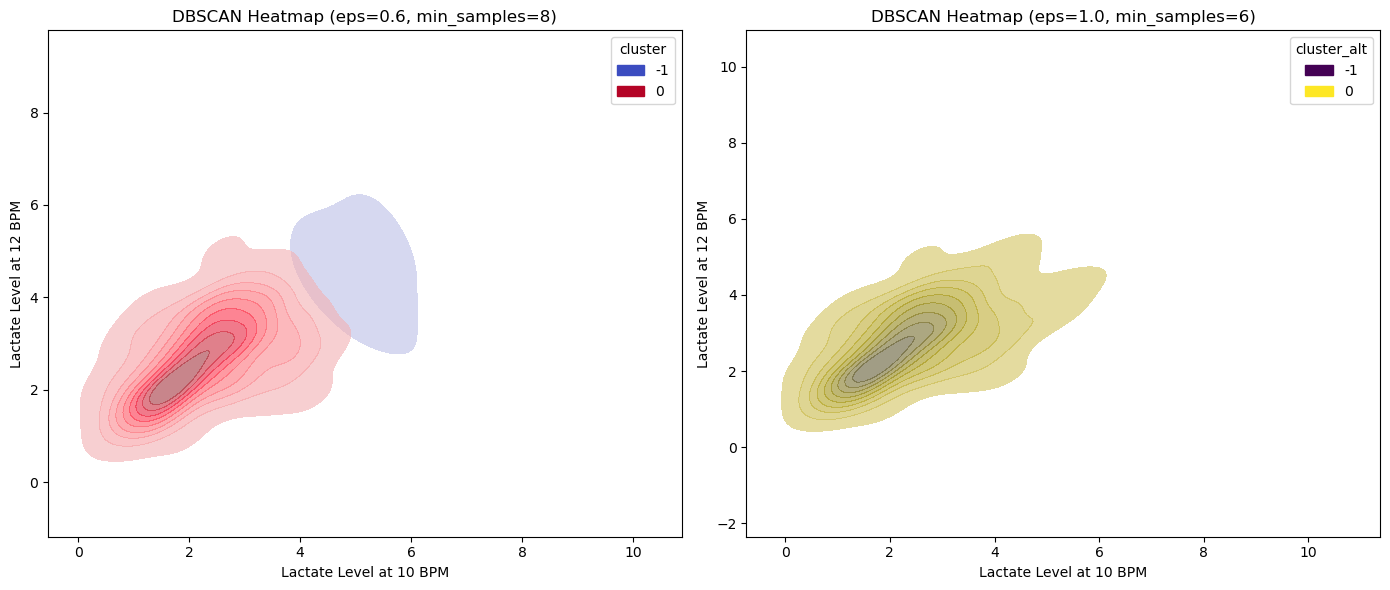


Porównanie średnich cech między klastrami dla pierwszej konfiguracji:
            vo2max       hrmax        age     weight      height
cluster                                                         
-1       50.136842  178.263158  40.578947  74.121053  178.578947
 0       53.205634  182.929577  34.725352  75.311972  177.091549

Porównanie średnich cech między klastrami dla drugiej konfiguracji:
                vo2max       hrmax        age     weight      height
cluster_alt                                                         
-1           49.618182  180.545455  41.909091  77.936364  182.818182
 0           53.080000  182.513333  34.940000  74.968667  176.860000


C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


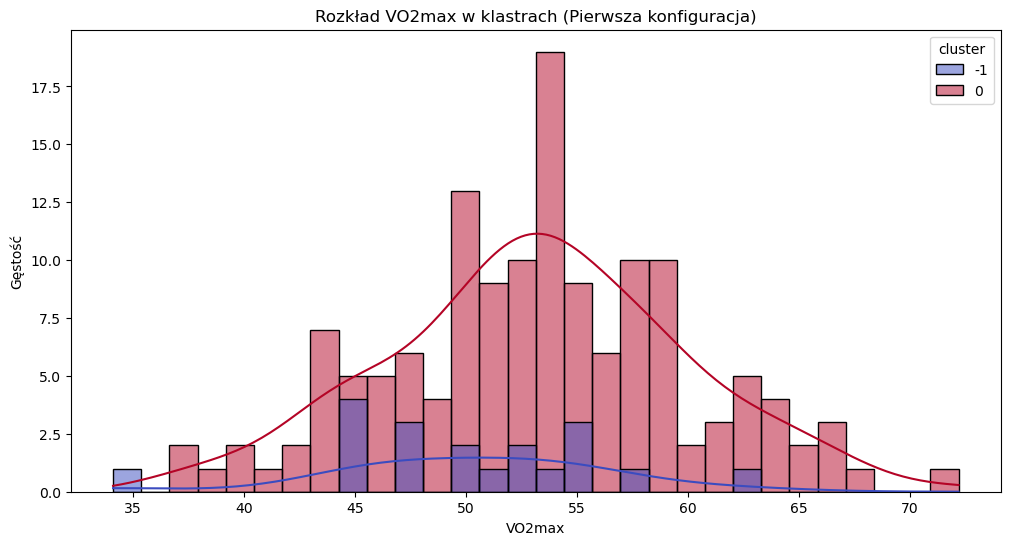

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


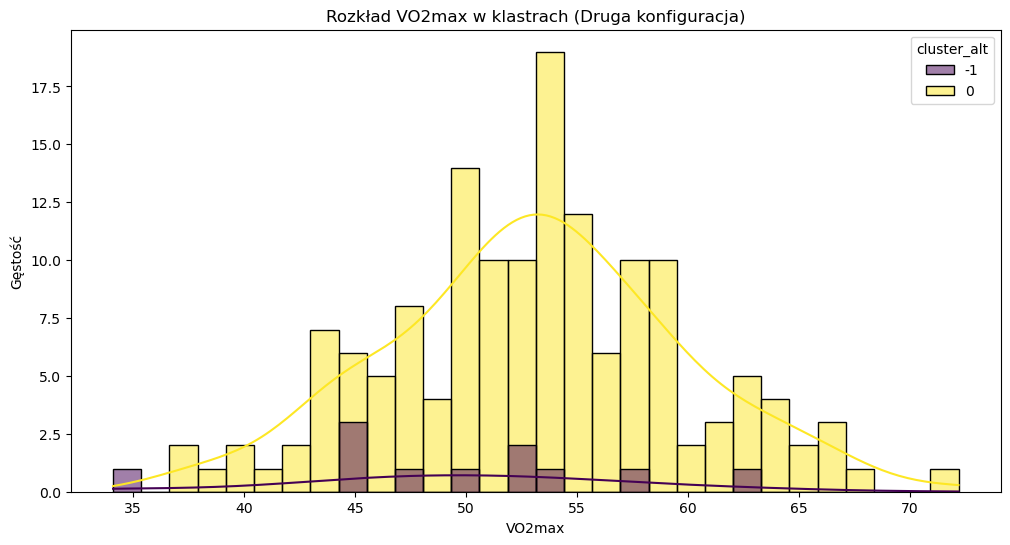

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

# Dane i parametry
# Przypuśćmy, że dane są załadowane do ramki danych "data"
data = data  # Przyjmuje że dane zostały wcześniej wczytane

# Przeprowadzanie DBSCAN dla dwóch konfiguracji
clustering1 = DBSCAN(eps=0.7, min_samples=8).fit(data[['la_10', 'la_12']])
data['cluster'] = clustering1.labels_

clustering2 = DBSCAN(eps=1.0, min_samples=6).fit(data[['la_10', 'la_12']])
data['cluster_alt'] = clustering2.labels_

# Analiza proporcji outlierów
def analyze_outliers(df, cluster_col):
    outliers = df[df[cluster_col] == -1]
    non_outliers = df[df[cluster_col] != -1]
    
    outlier_ratio = len(outliers) / len(df)
    print(f"Proporcja outlierów ({cluster_col}): {outlier_ratio:.2%}")
    print("\nCechy outlierów:")
    print(outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].describe())
    
    print("\nCechy nie-outlierów:")
    print(non_outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("Analiza pierwszej konfiguracji:")
analyze_outliers(data, 'cluster')
print("\nAnaliza drugiej konfiguracji:")
analyze_outliers(data, 'cluster_alt')

# Wizualizacja wykresów heatmap dla porównania klastrów
plt.figure(figsize=(14, 6))

# Pierwsza konfiguracja
plt.subplot(1, 2, 1)
sns.kdeplot(data=data, x='la_10', y='la_12', hue='cluster', fill=True, palette="coolwarm", alpha=0.6)
plt.title("DBSCAN Heatmap (eps=0.6, min_samples=8)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")

# Druga konfiguracja
plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='la_10', y='la_12', hue='cluster_alt', fill=True, palette="viridis", alpha=0.6)
plt.title("DBSCAN Heatmap (eps=1.0, min_samples=6)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")

plt.tight_layout()
plt.show()

# Porównanie średnich cech między klastrami
print("\nPorównanie średnich cech między klastrami dla pierwszej konfiguracji:")
print(data.groupby('cluster')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

print("\nPorównanie średnich cech między klastrami dla drugiej konfiguracji:")
print(data.groupby('cluster_alt')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

# Wizualizacja histogramów dla VO2max w klastrach
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster', kde=True, palette="coolwarm", bins=30)
plt.title("Rozkład VO2max w klastrach (Pierwsza konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='vo2max', hue='cluster_alt', kde=True, palette="viridis", bins=30)
plt.title("Rozkład VO2max w klastrach (Druga konfiguracja)")
plt.xlabel("VO2max")
plt.ylabel("Gęstość")
plt.show()

Accuracy: 1.00


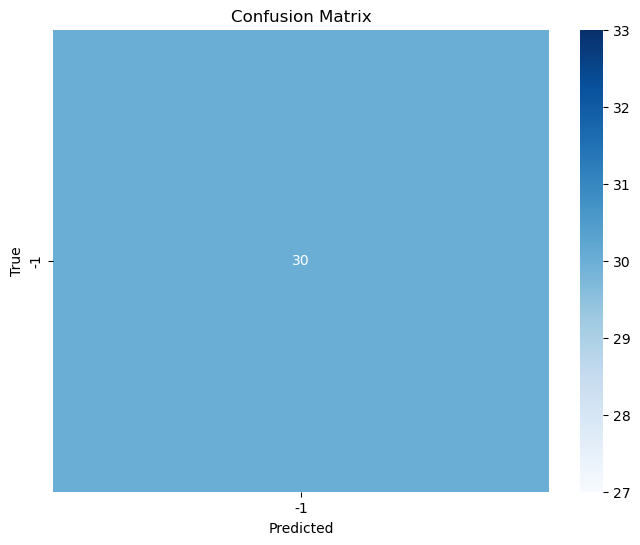

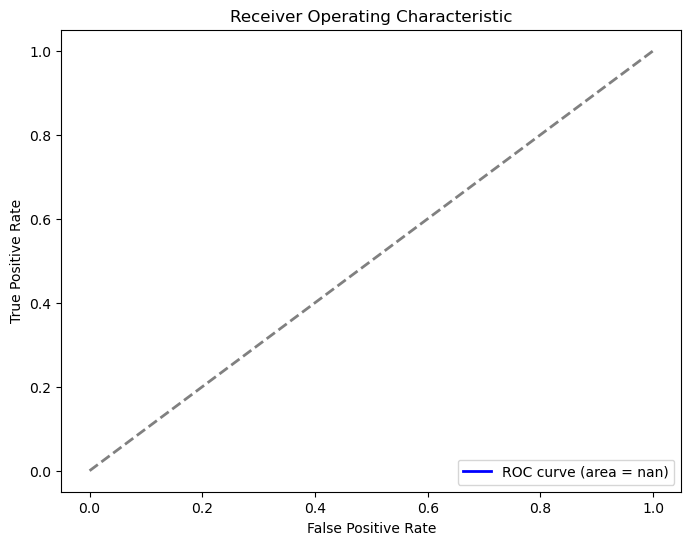

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

# Wczytanie danych i przygotowanie
X = df[['age', 'height', 'weight', 'vo2max']]  # Wybór cech
y = df['cluster']  # Zmienna docelowa (np. klaster)

# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Klasyfikator RandomForest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Ocena modelu
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
